# Model Comparison (Same Prompt)

This notebook runs multiple text-to-image models using the **same prompt** and the **same seeds**, then renders one side-by-side comparison figure: **rows = seeds**, **columns = models**.

Models compared:
- Stable Diffusion v1.4 (standard)
- Attend-and-Excite on SD v1.4
- Stable Diffusion 3.5 Medium (optional; requires Hugging Face access)

## Performance Settings
Set `FAST_MODE = True` for faster inference on smaller GPUs (reduces quality but speeds up generation).

In [1]:
# Set to True for faster inference on smaller GPUs
FAST_MODE = False # Change to True for faster generation with lower quality

if FAST_MODE:
    FAST_NUM_DIFFUSION_STEPS = 5
    FAST_IMAGE_SIZE = 64
    FAST_MAX_ITER_TO_ALTER = 5
else:
    FAST_NUM_DIFFUSION_STEPS = 50
    FAST_IMAGE_SIZE = 256
    FAST_MAX_ITER_TO_ALTER = 25

In [2]:
from typing import Callable, List, Optional, Tuple
import os
import sys

import torch
import matplotlib.pyplot as plt

sys.path.append('.')
sys.path.append('..')

from pipeline_attend_and_excite import AttendAndExcitePipeline
from config import RunConfig
from run import run_on_prompt
from utils.ptp_utils import AttentionStore

%load_ext autoreload
%autoreload 2

## Load SD v1.4 (Attend-and-Excite Pipeline)
This pipeline is used for both:
- standard SD v1.4 generation (by setting `run_standard_sd=True`)
- Attend-and-Excite generation (by setting `run_standard_sd=False`)

In [3]:
NUM_DIFFUSION_STEPS = FAST_NUM_DIFFUSION_STEPS
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float16 if torch.cuda.is_available() else torch.float32
print(f'Using device: {device} (dtype={dtype})')

stable = AttendAndExcitePipeline.from_pretrained(
    'CompVis/stable-diffusion-v1-4',
    torch_dtype=dtype,
).to(device)
tokenizer = stable.tokenizer

Using device: cuda:0 (dtype=torch.float16)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


## Helpers

In [4]:
def get_indices_to_alter_auto(prompt: str, stable_pipeline) -> List[int]:
    """Automatically extract token indices to alter without user input."""
    input_ids = stable_pipeline.tokenizer(prompt)["input_ids"]
    token_idx_to_word = {
        idx: stable_pipeline.tokenizer.decode(t)
        for idx, t in enumerate(input_ids)
        if 0 < idx < len(input_ids) - 1
    }

    stopwords = {"a", "an", "and", "the", "of", "in", "on", "at", "to", "for", "with", "by", "from"}
    token_indices = [
        idx for idx, word in token_idx_to_word.items() if word.strip().lower() not in stopwords
    ]

    print(f"Token mapping: {token_idx_to_word}")
    print(f"Auto-selected indices: {token_indices} -> {[token_idx_to_word[i] for i in token_indices]}")
    return token_indices


def run_sd14_image(
    prompt: str,
    seed: int,
    token_indices: Optional[List[int]],
    *,
    is_attend_and_excite: bool,
 ):
    """Generate one image with SD v1.4 (standard or Attend-and-Excite). Returns a PIL.Image."""
    if token_indices is None:
        token_indices = get_indices_to_alter_auto(prompt, stable)

    gen_device = "cuda" if torch.cuda.is_available() else "cpu"
    g = torch.Generator(gen_device).manual_seed(seed)

    controller = AttentionStore()
    run_standard_sd = not is_attend_and_excite

    thresholds = {0: 0.1} if FAST_MODE else {0: 0.05, 10: 0.5, 20: 0.8}
    config = RunConfig(
        prompt=prompt,
        run_standard_sd=run_standard_sd,
        scale_factor=20,
        thresholds=thresholds,
        max_iter_to_alter=FAST_MAX_ITER_TO_ALTER,
        sd_2_1=False,
    )

    out = run_on_prompt(
        model=stable,
        prompt=[prompt],
        controller=controller,
        token_indices=token_indices,
        seed=g,
        config=config,
    )

    return out.resize((FAST_IMAGE_SIZE, FAST_IMAGE_SIZE))

## Load Stable Diffusion 3.5 (Optional)
This model may require accepting terms on Hugging Face and providing a token.
If you don’t have access, the notebook will still run the SD v1.4 comparisons.

In [5]:
sd35_available = False
sd35 = None

try:
    from diffusers import AutoPipelineForText2Image
    from huggingface_hub import HfFolder

    MODEL_ID = "stabilityai/stable-diffusion-3.5-medium"
    HF_TOKEN = (
        os.environ.get("HF_TOKEN")
        or os.environ.get("HUGGINGFACE_HUB_TOKEN")
        or os.environ.get("HUGGINGFACE_TOKEN")
        or os.environ.get("HF_API_TOKEN")
        or HfFolder.get_token()
    )

    if HF_TOKEN is None:
        print(
            f"[sd3.5] No Hugging Face token found; skipping {MODEL_ID}.\n"
            "If you have access: set HF_TOKEN before starting the kernel (export HF_TOKEN=hf_...)\n"
            "or save a token to your HF cache, then restart the kernel."
        )
    else:
        sd35_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
        sd35 = AutoPipelineForText2Image.from_pretrained(
            MODEL_ID,
            torch_dtype=sd35_dtype,
            token=HF_TOKEN,
        )
        sd35 = sd35.to(device)
        sd35_available = True
        print(f"[sd3.5] Loaded {MODEL_ID} (dtype={sd35_dtype})")
except Exception as e:
    print(f"[sd3.5] Failed to load SD 3.5: {e}")
    sd35_available = False
    sd35 = None

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


[sd3.5] Loaded stabilityai/stable-diffusion-3.5-medium (dtype=torch.float16)


## Run All Models on the Same Prompt
Edit `PROMPT` and `SEEDS`, then run the next cell to generate the final side-by-side comparison figure.

Token mapping: {1: 'shep', 2: 'p', 3: '-', 4: 'logan', 5: 'model', 6: 'representing', 7: 'a', 8: 'scan', 9: 'of', 10: 'a', 11: 'normal', 12: '-', 13: 'sized', 14: 'brain', 15: ',', 16: 'significantly', 17: 'enlar', 18: 'ged', 19: 'ven', 20: 'tric', 21: 'les', 22: ',', 23: 'reduced', 24: 'white', 25: 'matter', 26: ',', 27: 'visible', 28: 'le', 29: 'sions'}
Auto-selected indices: [1, 2, 3, 4, 5, 6, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] -> ['shep', 'p', '-', 'logan', 'model', 'representing', 'scan', 'normal', '-', 'sized', 'brain', ',', 'significantly', 'enlar', 'ged', 'ven', 'tric', 'les', ',', 'reduced', 'white', 'matter', ',', 'visible', 'le', 'sions']


/gpfs/home2/sciarella/attend-and-excite/notebooks/../pipeline_attend_and_excite.py:489: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  num_channels_latents = self.unet.in_channels


  0%|          | 0/50 [00:00<?, ?it/s]

/home/sciarella/attend-and-excite/venv/lib64/python3.9/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:589: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/50 [00:00<?, ?it/s]

	 Try 1. normal has a max attention of 0.00930023193359375
	 Try 2. normal has a max attention of 0.00930023193359375
	 Try 3. normal has a max attention of 0.00930023193359375
	 Try 4. normal has a max attention of 0.00930023193359375
	 Try 5. normal has a max attention of 0.00930023193359375
	 Try 6. normal has a max attention of 0.00930023193359375
	 Try 7. normal has a max attention of 0.00930023193359375
	 Try 8. normal has a max attention of 0.009307861328125
	 Try 9. normal has a max attention of 0.009307861328125
	 Try 10. normal has a max attention of 0.009307861328125
	 Try 11. normal has a max attention of 0.009307861328125
	 Try 12. normal has a max attention of 0.009307861328125
	 Try 13. normal has a max attention of 0.009307861328125
	 Try 14. normal has a max attention of 0.00931549072265625
	 Try 15. normal has a max attention of 0.00931549072265625
	 Try 16. normal has a max attention of 0.00931549072265625
	 Try 17. normal has a max attention of 0.00931549072265625
	

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

	 Try 1. tric has a max attention of 0.009490966796875
	 Try 2. tric has a max attention of 0.00949859619140625
	 Try 3. tric has a max attention of 0.00949859619140625
	 Try 4. tric has a max attention of 0.0095062255859375
	 Try 5. tric has a max attention of 0.0095062255859375
	 Try 6. tric has a max attention of 0.0095062255859375
	 Try 7. tric has a max attention of 0.0095062255859375
	 Try 8. tric has a max attention of 0.0095062255859375
	 Try 9. tric has a max attention of 0.00951385498046875
	 Try 10. tric has a max attention of 0.00951385498046875
	 Try 11. tric has a max attention of 0.00951385498046875
	 Try 12. tric has a max attention of 0.00951385498046875
	 Try 13. le has a max attention of 0.009490966796875
	 Try 14. le has a max attention of 0.009490966796875
	 Try 15. le has a max attention of 0.00949859619140625
	 Try 16. le has a max attention of 0.00949859619140625
	 Try 17. le has a max attention of 0.00949859619140625
	 Try 18. le has a max attention of 0.009506

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

	 Try 1. tric has a max attention of 0.00749969482421875
	 Try 2. tric has a max attention of 0.007503509521484375
	 Try 3. tric has a max attention of 0.007518768310546875
	 Try 4. tric has a max attention of 0.007518768310546875
	 Try 5. tric has a max attention of 0.007526397705078125
	 Try 6. tric has a max attention of 0.007534027099609375
	 Try 7. tric has a max attention of 0.00754547119140625
	 Try 8. tric has a max attention of 0.007549285888671875
	 Try 9. tric has a max attention of 0.007556915283203125
	 Try 10. le has a max attention of 0.007518768310546875
	 Try 11. tric has a max attention of 0.007564544677734375
	 Try 12. le has a max attention of 0.007534027099609375
	 Try 13. le has a max attention of 0.007549285888671875
	 Try 14. le has a max attention of 0.00756072998046875
	 Try 15. normal has a max attention of 0.007724761962890625
	 Try 16. normal has a max attention of 0.0077972412109375
	 Try 17. normal has a max attention of 0.00786590576171875
	 Try 18. norm

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

	 Try 1. normal has a max attention of 0.00933837890625
	 Try 2. normal has a max attention of 0.00934600830078125
	 Try 3. normal has a max attention of 0.0093536376953125
	 Try 4. normal has a max attention of 0.00936126708984375
	 Try 5. normal has a max attention of 0.009368896484375
	 Try 6. normal has a max attention of 0.00937652587890625
	 Try 7. normal has a max attention of 0.00937652587890625
	 Try 8. normal has a max attention of 0.0093841552734375
	 Try 9. normal has a max attention of 0.00939178466796875
	 Try 10. normal has a max attention of 0.0093994140625
	 Try 11. normal has a max attention of 0.00940704345703125
	 Try 12. normal has a max attention of 0.00940704345703125
	 Try 13. normal has a max attention of 0.0094146728515625
	 Try 14. normal has a max attention of 0.00942230224609375
	 Try 15. normal has a max attention of 0.009429931640625
	 Try 16. normal has a max attention of 0.009429931640625
	 Try 17. normal has a max attention of 0.00943756103515625
	 Try

  0%|          | 0/50 [00:00<?, ?it/s]

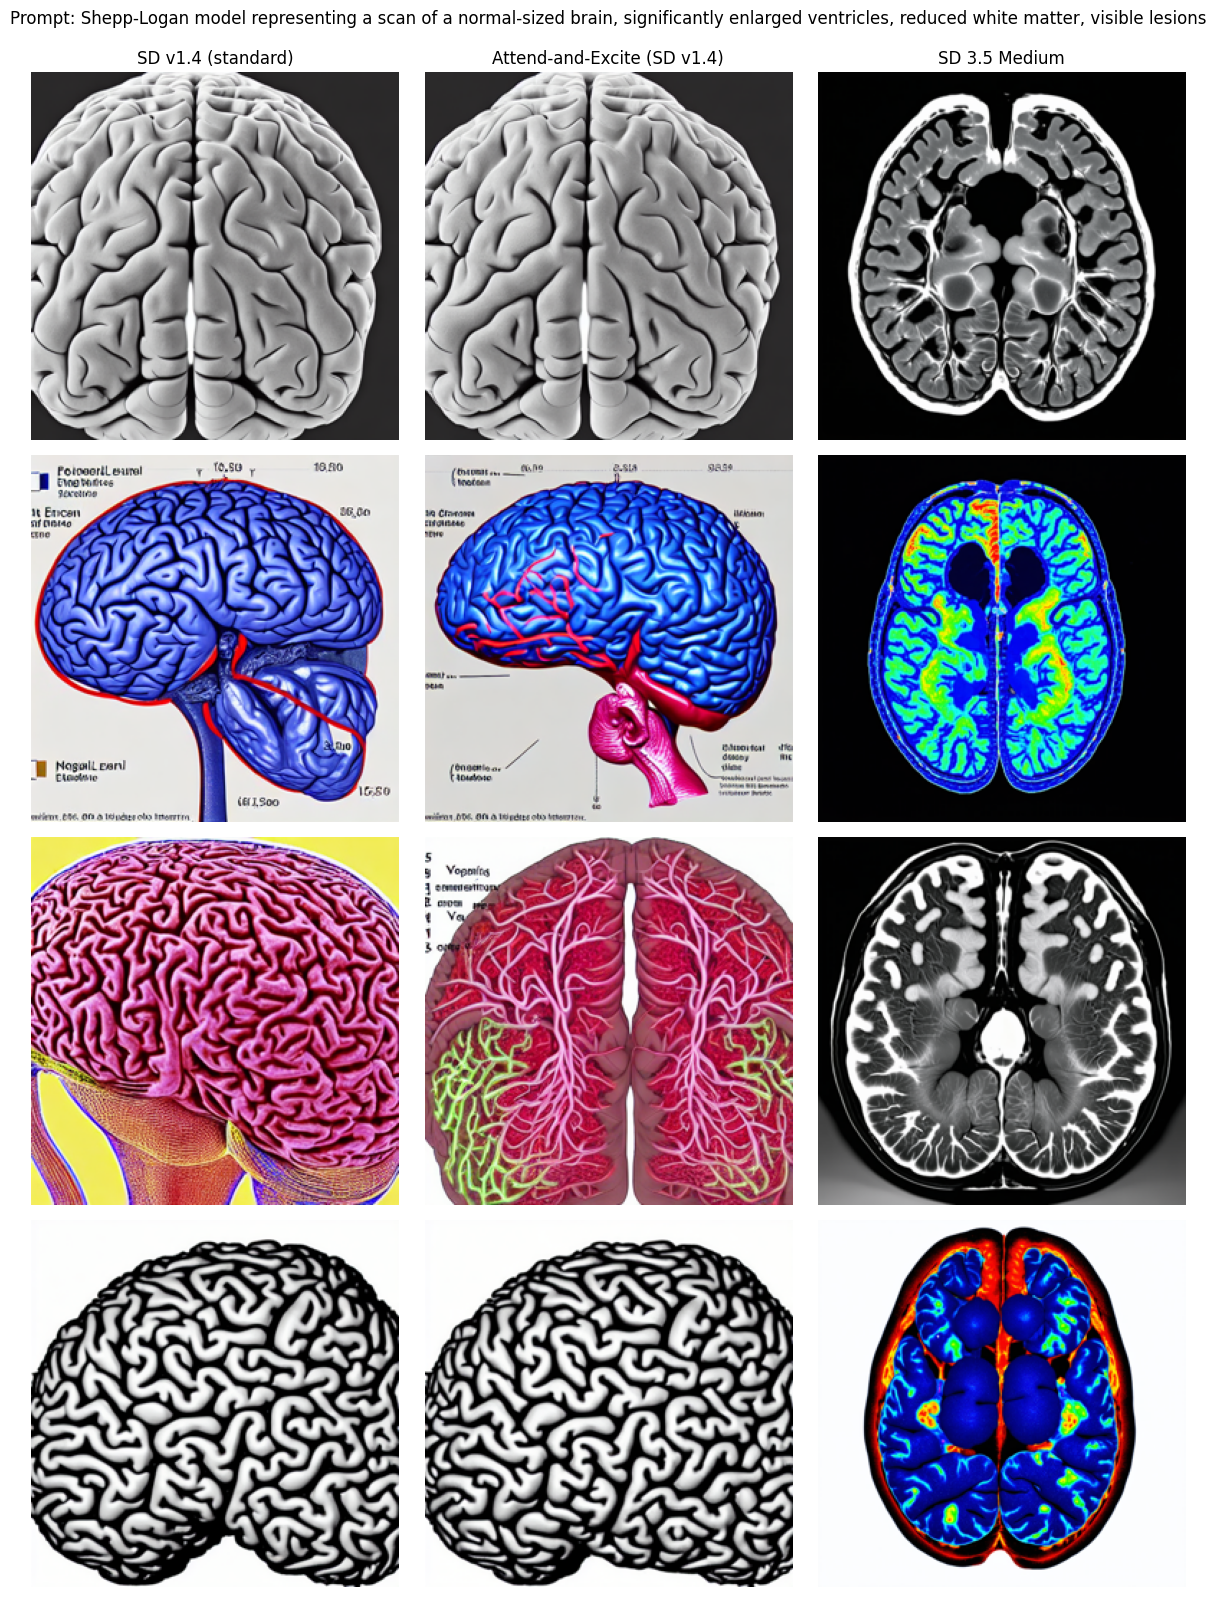

In [6]:
PROMPT = "a cat and a frog"
PROMPT = "Shepp-Logan model representing a scan of a normal-sized brain, significantly enlarged ventricles, reduced white matter, visible lesions"
SEEDS = [6141, 9031, 969, 1910]

# Keep token indices fixed across SD1.4 methods for a fairer comparison
token_indices = get_indices_to_alter_auto(PROMPT, stable)

def run_sd35_image(prompt: str, seed: int):
    gen = torch.Generator(device.type).manual_seed(seed)
    out = sd35(
        prompt=prompt,
        guidance_scale=GUIDANCE_SCALE,
        num_inference_steps=NUM_DIFFUSION_STEPS,
        generator=gen,
    )
    return out.images[0].resize((FAST_IMAGE_SIZE, FAST_IMAGE_SIZE))

model_runners: List[Tuple[str, Callable[[int], object]]] = [
    ("SD v1.4 (standard)", lambda seed: run_sd14_image(PROMPT, seed, token_indices, is_attend_and_excite=False)),
    ("Attend-and-Excite (SD v1.4)", lambda seed: run_sd14_image(PROMPT, seed, token_indices, is_attend_and_excite=True)),
]

if sd35_available:
    model_runners.append(("SD 3.5 Medium", lambda seed: run_sd35_image(PROMPT, seed)))
else:
    print("[compare] SD 3.5 not available; comparing SD v1.4 variants only.")

rows = len(SEEDS)
cols = len(model_runners)

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
if rows == 1 and cols == 1:
    axes = [[axes]]
elif rows == 1:
    axes = [axes]
elif cols == 1:
    axes = [[ax] for ax in axes]

for r, seed in enumerate(SEEDS):
    for c, (name, runner) in enumerate(model_runners):
        img = runner(seed)
        ax = axes[r][c]
        ax.imshow(img)
        ax.axis("off")
        if r == 0:
            ax.set_title(name)
        if c == 0:
            ax.set_ylabel(f"seed={seed}", rotation=0, labelpad=40, va="center")

fig.suptitle(f"Prompt: {PROMPT}", y=0.995)
plt.tight_layout()
plt.show()